In [3]:
# Importing essential libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Advanced Models
import xgboost as xgb
from sklearn.svm import SVC

# For handling warnings
import warnings
warnings.filterwarnings('ignore')

# For progress bars (optional)
from tqdm import tqdm


In [5]:
!pip install pandas numpy seaborn matplotlib scikit-learn xgboost tqdm


In [7]:
# Loading datasets
data_fake = pd.read_csv('Fake.csv')
data_true = pd.read_csv('True.csv')

# Displaying the first few rows of each dataset
print("Fake News Sample:")
display(data_fake.head())

print("\nTrue News Sample:")
display(data_true.head())

# Adding a 'class' column: 0 for fake, 1 for true
data_fake['class'] = 0
data_true['class'] = 1

# Display shapes
print(f"Fake News Shape: {data_fake.shape}")
print(f"True News Shape: {data_true.shape}")


Fake News Sample:


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"



True News Sample:


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Fake News Shape: (23481, 5)
True News Shape: (21417, 5)


In [9]:
# Combining the fake and true news datasets
data = pd.concat([data_fake, data_true], axis=0).reset_index(drop=True)
print(f"Combined Data Shape: {data.shape}")


Combined Data Shape: (44898, 5)


In [11]:
# Checking for missing values
print(data.isnull().sum())


title      0
text       0
subject    0
date       0
class      0
dtype: int64


In [13]:
# Dropping missing values
data.dropna(inplace=True)
print(f"Data Shape after dropping missing values: {data.shape}")


Data Shape after dropping missing values: (44898, 5)


In [15]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()  # Lowercasing
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in brackets
    text = re.sub(r'\\W', ' ', text)  # Remove non-word characters
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', ' ', text)  # Remove newline characters
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Applying the preprocessing function to the 'text' column
data['text'] = data['text'].apply(preprocess_text)


In [17]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove square brackets and contents within
    text = re.sub(r'$$.*?$$', '', text)
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove newline characters
    text = re.sub(r'\n', '', text)
    # Remove words containing digits
    text = re.sub(r'\w*\d\w*', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into string
    return ' '.join(tokens)

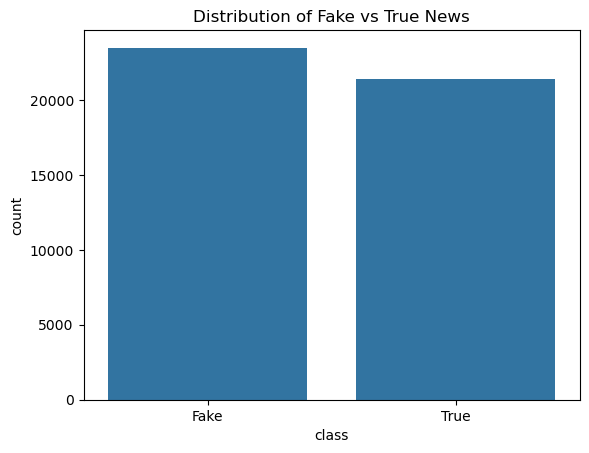

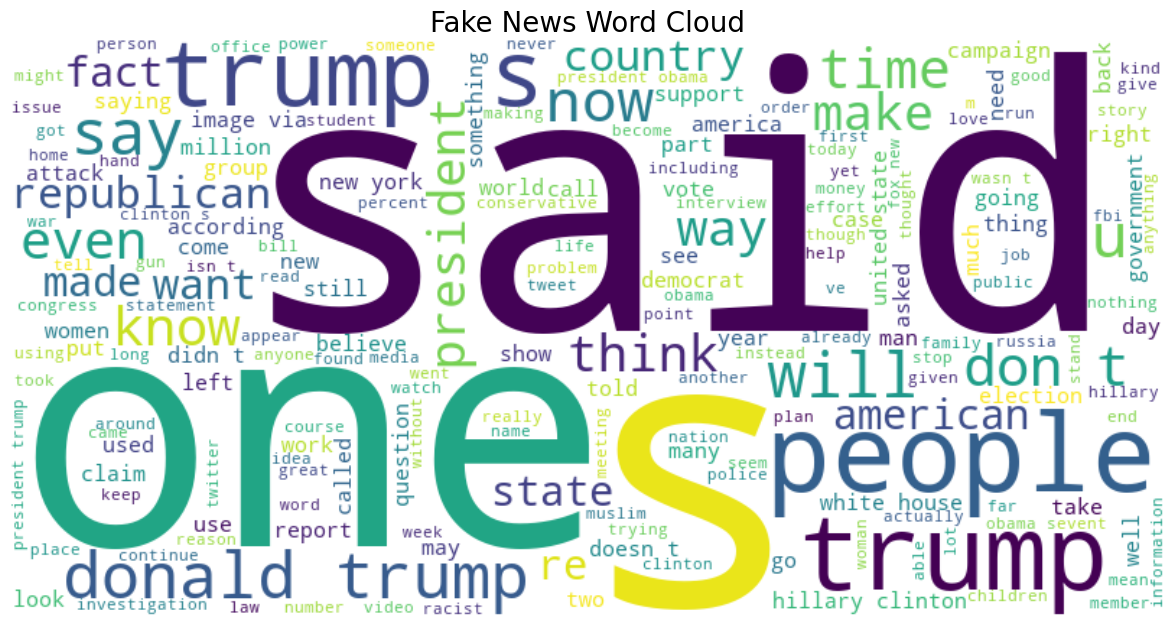

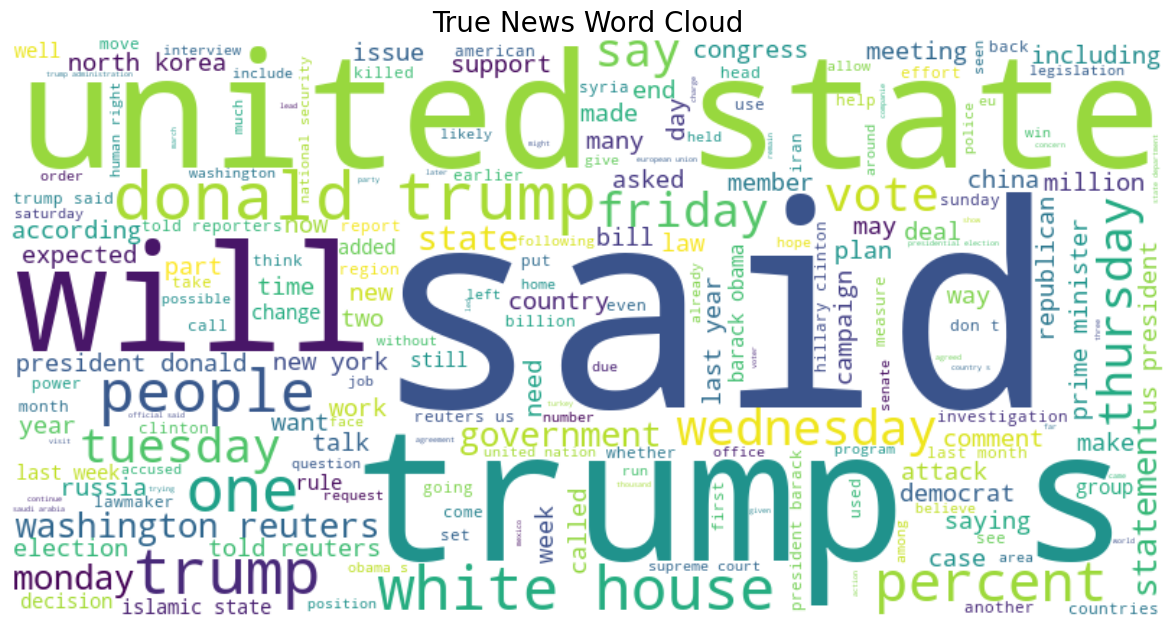

In [19]:
!pip install wordcloud

# Distribution of classes
sns.countplot(x='class', data=data)
plt.title('Distribution of Fake vs True News')
plt.xticks([0,1], ['Fake', 'True'])
plt.show()

# Word cloud for visualization (optional)
from wordcloud import WordCloud

# Function to plot word cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(15,7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

# Word cloud for Fake News
plot_wordcloud(data[data['class'] == 0]['text'], 'Fake News Word Cloud')

# Word cloud for True News
plot_wordcloud(data[data['class'] == 1]['text'], 'True News Word Cloud')


In [21]:
# Features and Labels
X = data['text']
y = data['class']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"Training Set Shape: {X_train.shape}")
print(f"Testing Set Shape: {X_test.shape}")


Training Set Shape: (33673,)
Testing Set Shape: (11225,)


In [25]:
# Initializing the TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # You can adjust max_features and ngram_range

# Fitting and transforming the training data
X_train_vect = vectorizer.fit_transform(X_train)

# Transforming the testing data
X_test_vect = vectorizer.transform(X_test)


In [27]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_vect, y_train)
lr_pred = lr.predict(X_test_vect)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_pred))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5871
           1       0.98      0.99      0.99      5354

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [29]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_vect, y_train)
dt_pred = dt.predict(X_test_vect)

print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_pred))


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5871
           1       1.00      0.99      1.00      5354

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [31]:
# Gradient Boosting Classifier
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_vect, y_train)
gb_pred = gb.predict(X_test_vect)

print("Gradient Boosting Classifier Report:")
print(classification_report(y_test, gb_pred))


Gradient Boosting Classifier Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5871
           1       0.99      1.00      1.00      5354

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [33]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_vect, y_train)
rf_pred = rf.predict(X_test_vect)

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5871
           1       1.00      1.00      1.00      5354

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [35]:
# XGBoost Classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_vect, y_train)
xgb_pred = xgb_model.predict(X_test_vect)

print("XGBoost Classifier Report:")
print(classification_report(y_test, xgb_pred))


XGBoost Classifier Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5871
           1       1.00      1.00      1.00      5354

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



Logistic Regression Accuracy: 0.9890
Decision Tree Accuracy: 0.9956
Gradient Boosting Accuracy: 0.9962
Random Forest Accuracy: 0.9972
XGBoost Accuracy: 0.9980


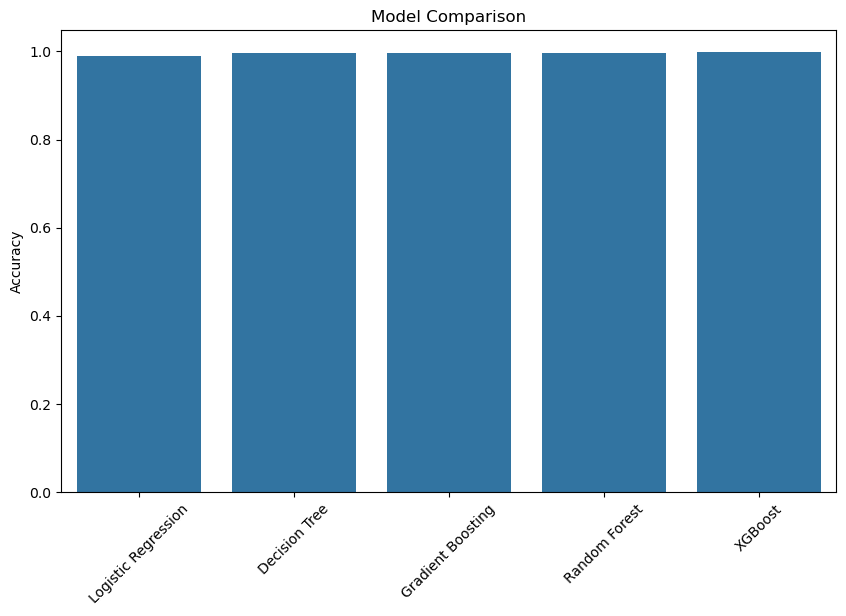

In [37]:
# Collecting model accuracies
models = {
    'Logistic Regression': lr,
    'Decision Tree': dt,
    'Gradient Boosting': gb,
    'Random Forest': rf,
    'XGBoost': xgb_model,
    # 'SVM': svm
}

# Evaluating and plotting accuracies
model_accuracy = {}
for model_name, model in models.items():
    accuracy = model.score(X_test_vect, y_test)
    model_accuracy[model_name] = accuracy
    print(f"{model_name} Accuracy: {accuracy:.4f}")

# Plotting the accuracies
plt.figure(figsize=(10,6))
sns.barplot(x=list(model_accuracy.keys()), y=list(model_accuracy.values()))
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.xticks(rotation=45)
plt.show()


In [53]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional: For enhanced lemmatization support


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [57]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
def preprocess_input(text):
    return preprocess_text(text)

def output_label(n):
    return "Fake News" if n == 0 else "True News"

def manual_testing(news, model):
    # Preprocess the input
    processed_news = preprocess_input(news)
    
    # Vectorize the input
    vect_news = vectorizer.transform([processed_news])
    
    # Predict using the specified model
    prediction = model.predict(vect_news)[0]
    
    # Return the result
    return output_label(prediction)

# Example usage
test_news = "The Chocklet Contains, H2so4"
print(f"Input News: {test_news}")
print(f"Prediction: {manual_testing(test_news, xgb_model)}")


Input News: The Chocklet Contains, H2so4
Prediction: Fake News
